# Benchmark

## Read the data

In [4]:
import os
import pandas as pd


sapsDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/saps_ii/saps_ii.csv')
predsDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/saps_ii/preds.csv')
datamatrixDf = pd.read_csv(os.environ['EICU_EHR_PIPELINE_BASE'] + '/data/final/data_matrix.csv')
sapsDf.shape, predsDf.shape

((9012, 4), (2216, 3))

## Combine the data

In [6]:
combinedDf = datamatrixDf[['person_id', 'visit_occurrence_id', 'death_adm']]\
    .merge(sapsDf, how='inner', on=['person_id', 'visit_occurrence_id'])\
        .merge(predsDf, how='inner', on=['person_id', 'visit_occurrence_id'])\
            .drop_duplicates()
combinedDf

,person_id,visit_occurrence_id,death_adm,saps_ii,saps_ii_pred,preds
0,248364,141515,0,49,0.437547,0.055872
7,238079,142483,0,47,0.391926,0.000161
37,22143,146788,0,23,0.052195,0.001853
38,210052,151900,0,21,0.041754,0.004518
41,26227,155503,0,60,0.680887,0.021447
...,...,...,...,...,...,...
8906,3511532,3348836,0,40,0.247443,0.017030
8910,3519950,3351084,0,23,0.052195,0.000006
8911,355785,3351708,1,63,0.736299,0.006140
8914,351704,3352358,0,51,0.483852,0.002894


## Plot

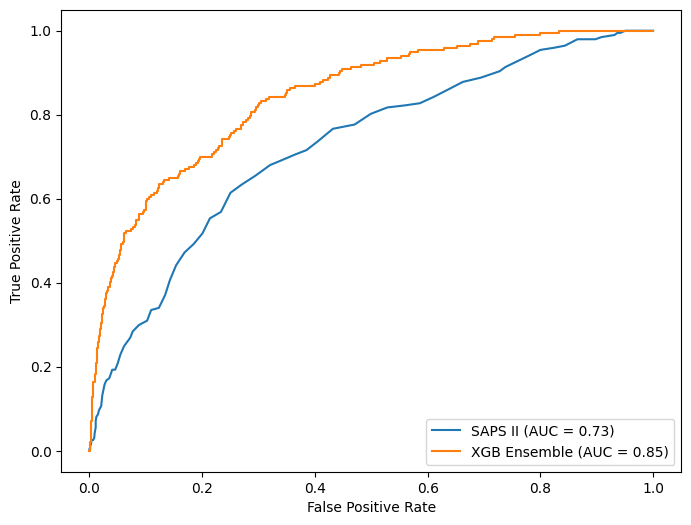

In [9]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from matplotlib import pyplot as plt


fig, ax = plt.subplots(figsize=(8, 6))
# plt.figure()

fpr, tpr, _  = roc_curve(combinedDf.death_adm, combinedDf.saps_ii_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='SAPS II')
display.plot(ax=ax)

fpr, tpr, _  = roc_curve(combinedDf.death_adm, combinedDf.preds)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='XGB Ensemble')
display.plot(ax=ax)

plt.show()